In [227]:
pip install pydicom

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [228]:
import pydicom
import os
import pandas as pd
import glob

# Exploratory Data Analysis

The dataset consists of multiple CT scans for 672 patients. These scans were performed using various parameters for Slice Thickness, Convolution Kernal, and Orientation. In order to run predictive models, we must use scans with consistent parameters. We must first determine which combination of these parameters is most suitable. 

## Identifying Scan Parameters from File Names

We first try to determine scan parameters by looking at their file names

In [232]:
# makes dataframe of patient id's and associated scan types

def get_file_names():
    # loads all direcory names as list of strings
    # files are located in a folder named datasets
    entries = glob.glob("/datasets/*/*")
    entries.sort()
    
    #removes '/datasets/' from direcory strings
    entries = [entry[10:] for entry in entries]
    
    #splits directory strings on '/'
    split_entries = [entry.split('/') for entry in entries]
    
    #combines directory string lists with common patient id 
    output_dict = {}
    for key, *values in split_entries:
        if key not in output_dict:
            output_dict[key] = [key]
        output_dict[key].extend(values)
        
    unique_entries = list(output_dict.values())
    
    #makes of list of patient id and scan folder names
    unique_entries_final = [(unique_entry[0],unique_entry[1:]) for unique_entry in unique_entries]
    
    entries_df = pd.DataFrame(unique_entries_final, columns=['id', 'scans'])
    
    return entries_df

In [230]:
entries_df = get_file_names()
entries_df

,id,scans
0,1005053246,"[Chest Topo, Chest low dose 1.0 B50f, Chest ..."
1,1005692582,"[Chest 1.0 B45f, Chest 10.0 MIP AXIAL, Ch..."
2,1011749283,"[A Chest 1.0 B45f, A Chest 10 MIP ax, A..."
3,1014372919,"[Chest Topo 0.6 T20s, Chest wo 1.0 B45f, C..."
4,1021652756,"[Chest 1.0 B45f, Chest 10.0 MIP AXIAL, Ch..."
...,...,...
667,9705401851,"[Chest Topo 0.6 T20s, Chest wo 1.0 B45f, C..."
668,9820417218,"[Chest Topo, Lung Low Dose 1.0 Br49, Lung Lo..."
669,9842687566,"[Chest Topo 0.6 T20s, Chest wo 1.0 B45f, C..."
670,9954178646,"[Chest Topo 0.6 T20s, Chest wo 1.0 B45f, C..."


In [233]:
from collections import Counter

#determine the muber of instances of each unique scan name
scan_counter = Counter()

for scan_list in entries_df["scans"]:
    for scan in scan_list:
        scan_counter[scan] += 1

print('The number of unique folder names is: ' + str(len(scan_counter)))

scan_counts_df = pd.DataFrame(scan_counter.most_common(), columns=['Scan Name', 'Number of Scans'])
with pd.option_context("display.max_rows", 10): 
    display(scan_counts_df)

The number of unique folder names is: 203


,Scan Name,Number of Scans
0,Chest Topo 0.6 T20s,433
1,Chest wo 10.0 - Cor MIP,233
2,Chest wo 10.0 - Sag MIP,233
3,Chest wo 3.0 B45f,233
4,Chest wo 1.0 B45f,232
...,...,...
198,Chest 1.0 MPR ax,1
199,A Chest 10 MIP axial,1
200,10X10 AXIAL MIP,1
201,10X10 COR MIP,1


Because of inconsistant file naming convenctions, there are over 200 unique file names for the scans of the 672 patients. The difficuty in determining parameter values for the individual scans based on these file names means another approach is necessary.

## Identifying Scan Parameters from Dicom Metadata

Each dicom file includes metadata pertaining to the scan that produced it. By looking at the metadata for each set of scans, we can determine which combination of parameter values to use for the training of our models. 

In [234]:
#make list of directories for first file in each folder 

import os

def get_first_file_in_every_folder(root_directory):
    first_files = []
    for dirpath, dirnames, filenames in os.walk(root_directory):
        if filenames:
            filenames.sort()
            first_file = os.path.join(dirpath, filenames[0])
            first_files.append(first_file)
    return first_files

## UCLA Dicom Dataset

In [824]:
root_directory = "/datasets"
first_files = get_first_file_in_every_folder(root_directory)

In [825]:
first_files.sort()

In [237]:
first_files[0:5]

['/datasets/1005053246/Chest Topo/1.dcm',
 '/datasets/1005053246/Chest low dose  1.0  B50f/1.dcm',
 '/datasets/1005053246/Chest low dose  3.0  B50f/1.dcm',
 '/datasets/1005053246/axial mip/1.dcm',
 '/datasets/1005053246/coronal mip/1.dcm']

In [826]:
# remove codebook file from list of directories 

first_files.remove('/datasets/Code_book.xlsx')

'/datasets/Code_book.xlsx' in first_files

False

In [827]:
#make list of dicom files based on list of directories

first_diacom_per_file = []

for scan in first_files:
        first_diacom_per_file.append(pydicom.dcmread(scan,force=True))

In [828]:
#remove files that cause error

del first_diacom_per_file[719]
del first_diacom_per_file[3771]
del first_diacom_per_file[4735]

In [829]:
#remove corresponding entries in first_files list

del first_files[719]
del first_files[3771]
del first_files[4735]

In [830]:
# pickle list for use in other notebooks 

import pickle

# Specify the directory and filename
directory = '/workspace/home/'
filename = 'first_diacom_per_file_ucla.pkl'
file_path = os.path.join(directory, filename)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the numpy array to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(first_diacom_per_file, file)

In [243]:
#check metadata of first dicom file 

first_diacom_per_file[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.51964.30000016050615035692100000102
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'LOCALIZER', 'CT_SOM5 TOP']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.51964.30000016050615035692100000102
(0008, 0020) Study Date      

In [244]:
#make a list of desired dicom metadata properties

dicom_metadata_list = []
index = 0

for diacom in first_diacom_per_file:
    dicom_metadata_list.append([diacom.AccessionNumber, diacom.SliceThickness, diacom.ConvolutionKernel,
                                diacom.ImageOrientationPatient, diacom.PatientID, index])
    index += 1

In [246]:
diacom_metadata_df = pd.DataFrame(dicom_metadata_list, columns=['AccessionNumber', 'SliceThickness', 'ConvolutionKernel'
                                                               ,'ImageOrientationPatient', 'Patient ID', "Directory Index"])
diacom_metadata_df.head(5)

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index
0,1005053246,1.0,T20s,"[1, 6.123031769e-017, 0, 0, 0, -1]",2460458378,0
1,1005053246,1.0,B50f,"[1, 0, 0, 0, 1, 0]",2460458378,1
2,1005053246,3.0,B50f,"[1, 0, 0, 0, 1, 0]",2460458378,2
3,1005053246,10.0,B50f,"[1, 1.224606354e-016, -7.10542736e-015, -1.224...",2460458378,3
4,1005053246,10.0,B50f,"[1, 0, 0, 0, 0, -1]",2460458378,4


In [247]:
#function to determine ct orientation based on 'ImageOrientationPatient' column

def ct_orientation(index):

    image_orientation_patient_string = str(diacom_metadata_df['ImageOrientationPatient'].iloc[index])
    image_vectors = image_orientation_patient_string.replace('[','').replace(']','').split(',')
    image_vectors = [round(float(x)) for x in image_vectors]

    #[1,0,0,0,1,0]
    if image_vectors[0] == 1 and image_vectors[4] == 1: 
        return 'axial'
    
    #[0,1,0,0,0,-1]
    elif image_vectors[1] == 1 and image_vectors[5] == -1: 
        return 'sagittal'
    
    #[1,0,0,0,0,-1]
    elif image_vectors[0] == 1 and image_vectors[5] == -1: 
        return 'coronal'
    
    else:
        return 'unknown'

In [248]:
#add column for scan orientation

orientation = []
for index in range(len(diacom_metadata_df)):
    orientation.append(ct_orientation(index))
    
diacom_metadata_df['Orientation'] = orientation
diacom_metadata_df.head(10)

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index,Orientation
0,1005053246,1.0,T20s,"[1, 6.123031769e-017, 0, 0, 0, -1]",2460458378,0,coronal
1,1005053246,1.0,B50f,"[1, 0, 0, 0, 1, 0]",2460458378,1,axial
2,1005053246,3.0,B50f,"[1, 0, 0, 0, 1, 0]",2460458378,2,axial
3,1005053246,10.0,B50f,"[1, 1.224606354e-016, -7.10542736e-015, -1.224...",2460458378,3,axial
4,1005053246,10.0,B50f,"[1, 0, 0, 0, 0, -1]",2460458378,4,coronal
5,1005053246,2.0,B50f,"[1, 0, 0, 0, 0, -1]",2460458378,5,coronal
6,1005053246,10.0,B50f,"[6.123031769e-017, 1, 0, 0, 0, -1]",2460458378,6,sagittal
7,1005053246,2.0,B50f,"[6.123031769e-017, 1, 0, 0, 0, -1]",2460458378,7,sagittal
8,1005692582,1.0,B45f,"[1, 0, 0, 0, 1, 0]",2467550964,8,axial
9,1005692582,10.0,B45f,"[1, 0, 0, 0, 1, 0]",2467550964,9,axial


In [249]:
#example of folder containing different coordinate types

diacom_metadata_df.loc[diacom_metadata_df['AccessionNumber'] == '2916785364']

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index,Orientation
3323,2916785364,NaN,Tr20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",1998834231,3323,coronal
3324,2916785364,1.0,"[Br49d, 3]","[1, 0, 0, 0, 1, 0]",1998834231,3324,axial
3325,2916785364,1.0,Br49d,"[1, 0, 0, 0, 1, 0]",1998834231,3325,axial
3326,2916785364,10.0,Br49d,"[0.99891122848408, -0.016735876424, -0.0435461...",1998834231,3326,axial
3327,2916785364,10.0,Br49d,"[0.99891122848408, -0.016735876424, -0.0435461...",1998834231,3327,coronal
3328,2916785364,10.0,Br49d,"[0.016751766015, 0.99985967932274, 0, -0.00603...",1998834231,3328,sagittal
3329,2916785364,2.0,Br49d,"[0.99891122848408, -0.016735876424, -0.0435461...",1998834231,3329,coronal
3330,2916785364,2.0,Br49d,"[0.016751766015, 0.99985967932274, 0, -0.04354...",1998834231,3330,sagittal
3331,2916785364,3.0,Br49d,"[1, 0, 0, 0, 1, 0]",1998834231,3331,axial


In [250]:
print('The unique Slice Thickness values and their counts are:')
diacom_metadata_df['SliceThickness'].value_counts()

The unique Slice Thickness values and their counts are:


SliceThickness
10.0    1977
2.0     1315
1.0      818
3.0      676
0.6       99
9.6        1
Name: count, dtype: int64

<Axes: title={'center': 'Slice Thickness Frequency'}, xlabel='Slice Thickness'>

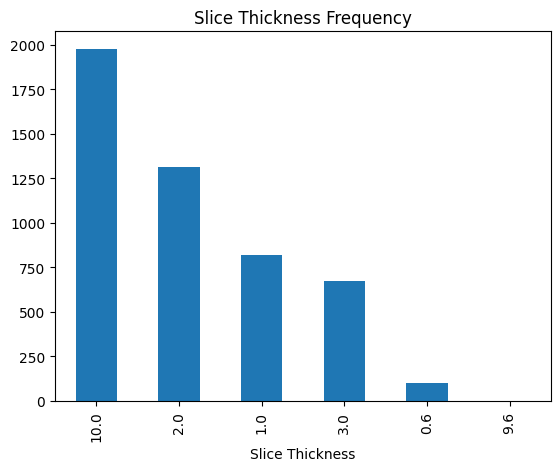

In [251]:
diacom_metadata_df['SliceThickness'].value_counts().plot(kind='bar', xlabel ='Slice Thickness', title = 'Slice Thickness Frequency')

In [252]:
print('The unique Convolution Kernel values and their counts are:')
diacom_metadata_df['ConvolutionKernel'].value_counts()

The unique Convolution Kernel values and their counts are:


ConvolutionKernel
B45f          3679
T20f           532
Br49d          525
B46f           255
B50f           185
Tr20f           75
[Br49d, 3]      74
T20s            67
B35f             1
B30s             1
Name: count, dtype: int64

<Axes: title={'center': 'Convolution Kernel Frequency'}, xlabel='Convolution Kernel'>

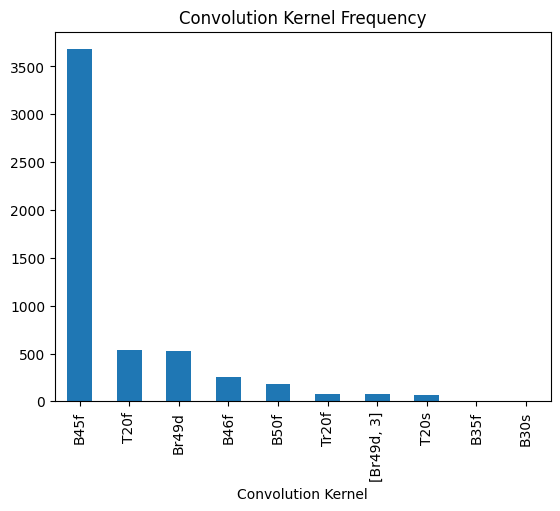

In [253]:
diacom_metadata_df['ConvolutionKernel'].value_counts().plot(kind='bar', xlabel ='Convolution Kernel', title = 'Convolution Kernel Frequency')

In [254]:
print('The unique Orientation values and their counts are:')
diacom_metadata_df['Orientation'].value_counts()

The unique Orientation values and their counts are:


Orientation
axial       2323
coronal     1970
sagittal    1098
unknown        3
Name: count, dtype: int64

<Axes: title={'center': 'Orientation Frequency'}, xlabel='Orientation'>

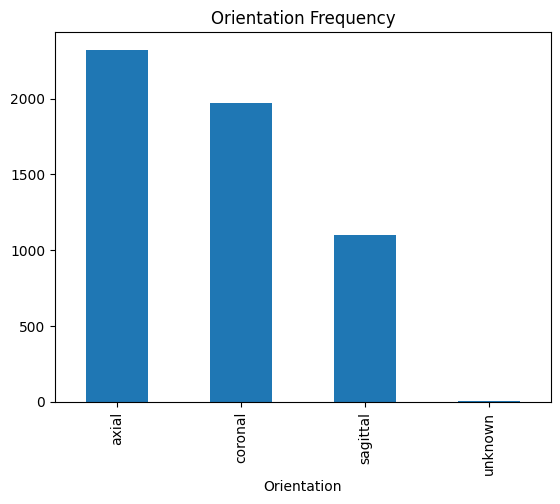

In [255]:
diacom_metadata_df['Orientation'].value_counts().plot(kind='bar', xlabel ='Orientation', title = 'Orientation Frequency')

In [256]:
#check number of rows that have a null value

print(diacom_metadata_df.isnull().sum())

AccessionNumber              0
SliceThickness             508
ConvolutionKernel            0
ImageOrientationPatient      0
Patient ID                   0
Directory Index              0
Orientation                  0
dtype: int64


In [257]:
#make dataframe of rows with null value 

nan_mask = pd.isnull(diacom_metadata_df).any(axis=1)
nan_df = diacom_metadata_df[nan_mask]

In [110]:
nan_df.tail(10)

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index,Orientation
5313,9352202043,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",1106309862,5313,coronal
5328,9383866191,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",3363087039,5328,coronal
5329,9404267413,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",2336620092,5329,coronal
5337,9421256107,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",2449579961,5337,coronal
5345,9658298987,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",2524892927,5345,coronal
5353,9705401851,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",3832132434,5353,coronal
5361,9820417218,NaN,Tr20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",6117165282,5361,coronal
5370,9842687566,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",1536615107,5370,coronal
5378,9954178646,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",3200298660,5378,coronal
5386,9971061671,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",9903677335,5386,coronal


In [258]:
#entries with null slice thickness are contained in folders entitled 'Topo'

diacom_metadata_df.loc[diacom_metadata_df['AccessionNumber'] == '1021652756']

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index,Orientation
32,1021652756,1.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,32,axial
33,1021652756,10.0,B45f,"[1, 0, 0, 0, 0, -1]",3398671109,33,coronal
34,1021652756,10.0,B45f,"[0.010626396151, 0.99994353825846, 0, 0, 0, -1]",3398671109,34,sagittal
35,1021652756,10.0,B45f,"[0.9999867451123, -0.005148747392, 0, 0, 0, -1]",3398671109,35,coronal
36,1021652756,2.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,36,axial
37,1021652756,2.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,37,axial
38,1021652756,3.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,38,axial
39,1021652756,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",3398671109,39,coronal


In [259]:
#make new dataframe ommiting null values
diacom_no_nans_df = diacom_metadata_df[~diacom_metadata_df.isnull().any(axis=1)]

print(diacom_no_nans_df.isnull().sum())

AccessionNumber            0
SliceThickness             0
ConvolutionKernel          0
ImageOrientationPatient    0
Patient ID                 0
Directory Index            0
Orientation                0
dtype: int64


In [260]:
#cast 'ConvolutionKernel' to string to deal with ['Br49d', '3'] value
diacom_no_nans_df['ConvolutionKernel'] = diacom_no_nans_df['ConvolutionKernel'].astype(str)

#calculate the counts for different combinations of features
feature_count_df = diacom_no_nans_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})

/tmp/ipykernel_2649269/43587305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diacom_no_nans_df['ConvolutionKernel'] = diacom_no_nans_df['ConvolutionKernel'].astype(str)


## NLST Dicom Dataset

In [568]:
root_directory_nlst = "/workspace/home/sybil_test"

first_files_nlst = get_first_file_in_every_folder(root_directory_nlst)

In [571]:
first_files_nlst.sort()

In [572]:
# pickle list for use in other notebooks 

import pickle

# Specify the directory and filename
directory = '/workspace/home/'
filename = 'first_files_nlst.pkl'
file_path = os.path.join(directory, filename)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the numpy array to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(first_files_nlst, file)

In [577]:
first_files_nlst[-10:]

['/workspace/home/sybil_test/218872/01-02-1999-NA-NLST-ACRIN-21146/3.000000-0OPASESEN4B50f300512040202-18705/1-01.dcm',
 '/workspace/home/sybil_test/218872/01-02-1999-NA-NLST-ACRIN-21146/4.000000-0OPASESEN4B30f300212040202-50581/1-001.dcm',
 '/workspace/home/sybil_test/218872/01-02-2000-NA-NLST-ACRIN-72563/1.000000-1OPLSESEN4T20s512180251.52511-48012/1-1.dcm',
 '/workspace/home/sybil_test/218872/01-02-2000-NA-NLST-ACRIN-72563/2.000000-1OPASESEN4B50f320212040202-58224/1-001.dcm',
 '/workspace/home/sybil_test/218872/01-02-2000-NA-NLST-ACRIN-72563/3.000000-1OPASESEN4B50f320512040202-37201/1-01.dcm',
 '/workspace/home/sybil_test/218872/01-02-2000-NA-NLST-ACRIN-72563/4.000000-1OPASESEN4B30f320212040202-36450/1-001.dcm',
 '/workspace/home/sybil_test/218872/01-02-2001-NA-NLST-ACRIN-99932/1.000000-2OPLSESEN4T20s5121802222221-17630/1-1.dcm',
 '/workspace/home/sybil_test/218872/01-02-2001-NA-NLST-ACRIN-99932/2.000000-2OPASESEN4B50f338212040202-68570/1-001.dcm',
 '/workspace/home/sybil_test/21887

In [589]:
first_files_nlst[50]

'/workspace/home/sybil_test/100095/01-02-1999-NA-NLST-LSS-75830/0.000000-0OPLPHMX8000UNK500na90null1.0null-67599/1-1.dcm'

In [576]:
# remove license file from list of directories 

first_files_nlst.remove('/workspace/home/sybil_test/LICENSE')


In [578]:
#make list of dicom files based on list of directories

first_diacom_per_nlst_file = []

for scan in first_files_nlst:
        first_diacom_per_nlst_file.append(pydicom.dcmread(scan,force=True))

In [686]:
# example of dicom metadata

#first_diacom_per_nlst_file[0]

In [688]:
# example of dicom metadata missing ConvolutionKernel

# first_diacom_per_nlst_file[50]

In [619]:
#make a list of desired dicom metadata properties

def make_dicom_metadata_df(dicom_list, directory_list):
    dicom_metadata_list = []
    index = 0

    for dicom in dicom_list:
        
        if hasattr(dicom, 'ConvolutionKernel') and dicom.ConvolutionKernel is not None:
            dicom_metadata_list.append([dicom.AccessionNumber, dicom.SliceThickness, dicom.ConvolutionKernel,
                                        dicom.ImageOrientationPatient, dicom.PatientID, index, directory_list[index]])
 
            index += 1
    
        elif hasattr(dicom, 'SliceThickness') and dicom.SliceThickness is not None:
            
            dicom_metadata_list.append([dicom.AccessionNumber, dicom.SliceThickness, "missing",
                                        dicom.ImageOrientationPatient, dicom.PatientID, index, directory_list[index]])
            index +=1
            
        elif hasattr(dicom, 'ImageOrientationPatient') and dicom.SliceThickness is not None:
            
            dicom_metadata_list.append([dicom.AccessionNumber, 'missing', "missing",
                                        dicom.ImageOrientationPatient, dicom.PatientID, index, directory_list[index]])
            index +=1
              
        else:
            dicom_metadata_list.append([dicom.AccessionNumber, 'missing', "missing",
                                        'missing', dicom.PatientID, index, directory_list[index]])
            print(index)
            index +=1

        
    diacom_metadata_df = pd.DataFrame(dicom_metadata_list, columns=['AccessionNumber', 'SliceThickness', 'ConvolutionKernel'
                                                               ,'ImageOrientationPatient', 'Patient_ID',"index", "Directory"])
    return diacom_metadata_df

In [620]:
nlst_diacom_metadata_df = make_dicom_metadata_df(first_diacom_per_nlst_file, first_files_nlst)

16783


In [644]:
nlst_diacom_metadata_df['ConvolutionKernel'].value_counts()

ConvolutionKernel
STANDARD         4840
B30f             3329
B50f             2719
T20s             2237
EXPERIMENTAL7    1803
BONE             1776
FL01              537
FC51              529
C                 480
missing           456
LUNG              347
D                 319
FC10              122
B                  45
FC11               34
FC30               30
FC01               24
B60f               21
A                  13
B70f               10
FC02                7
B80f                5
FC50                4
FC82                3
FC53                2
B20f                2
B30s                2
B60s                1
FL04                1
B31f                1
B50s                1
B45f                1
B40f                1
BONEPLUS            1
Name: count, dtype: int64

In [ ]:
#add column for scan orientation

orientation = []
for index in range(len(diacom_metadata_df)):
    orientation.append(ct_orientation(index))
    
diacom_metadata_df['Orientation'] = orientation
diacom_metadata_df.head(10)

In [635]:
#function to determine ct orientation based on 'ImageOrientationPatient' column

def get_ct_orientation(df, index):

    image_orientation_patient_string = str(df['ImageOrientationPatient'].iloc[index])
    image_vectors = image_orientation_patient_string.replace('[','').replace(']','').split(',')
    image_vectors = [round(float(x)) for x in image_vectors]

    #[1,0,0,0,1,0]
    if image_vectors[0] == 1 and image_vectors[4] == 1: 
        return 'axial'
    
    #[0,1,0,0,0,-1]
    elif image_vectors[1] == 1 and image_vectors[5] == -1: 
        return 'sagittal'
    
    #[1,0,0,0,0,-1]
    elif image_vectors[0] == 1 and image_vectors[5] == -1: 
        return 'coronal'
    
    else:
        return 'unknown'

In [638]:
#add column for scan orientation

def add_orientation_column(dicom_df):
    orientation = []
    
    for index in range(len(dicom_df)):
        if str(dicom_df['ImageOrientationPatient'].iloc[index]) == 'missing':
            orientation.append('missing')
        else:
            orientation.append(get_ct_orientation(dicom_df, index))

    dicom_df['Orientation'] = orientation


In [639]:
add_orientation_column(nlst_diacom_metadata_df)

# Making a Dataset of Usable Scans UCLA

In [261]:
feature_count_df = feature_count_df.sort_values('count', ascending=False)

In [262]:
feature_count_df.head(10)

,SliceThickness,ConvolutionKernel,Orientation,count
29,10.0,B45f,axial,579
30,10.0,B45f,coronal,560
2,1.0,B45f,axial,531
21,3.0,B45f,axial,530
11,2.0,B45f,coronal,466
31,10.0,B45f,sagittal,445
12,2.0,B45f,sagittal,402
10,2.0,B45f,axial,166
0,0.6,T20f,coronal,98
40,10.0,Br49d,sagittal,88


In [263]:
#want entries with following properties:
#SliceThickness = 1.0, ConvolutionKernel = B45f, Orientation = axial
#this is the one used

reduced_df = diacom_metadata_df[(diacom_metadata_df['SliceThickness'] == 1.0) & (diacom_metadata_df['Orientation'] == 'axial')
                               & (diacom_metadata_df['ConvolutionKernel'] == 'B45f')]

In [270]:
#check features of ommited patients

#creates dataframe of patients not included in other dataset
ommitted_df = diacom_no_nans_df[~diacom_no_nans_df['AccessionNumber'].isin(reduced_df['AccessionNumber'].tolist())]
ommitted_feature_count_df = test_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
ommitted_feature_count_df = test_feature_count_df.sort_values('count', ascending=False)
ommitted_feature_count_df

,SliceThickness,ConvolutionKernel,Orientation,count
28,10.0,Br49d,sagittal,88
3,1.0,Br49d,axial,75
19,3.0,Br49d,axial,75
27,10.0,Br49d,coronal,74
6,1.0,"['Br49d', '3']",axial,74
5,1.0,T20s,coronal,67
12,2.0,Br49d,coronal,62
26,10.0,Br49d,axial,62
13,2.0,Br49d,sagittal,62
21,10.0,B46f,coronal,39


In [359]:
#check entries with following properties:
#SliceThickness = 1.0, ConvolutionKernel = Br49d, Orientation = axial

reduced_df_br49d = ommitted_df[(ommitted_df['SliceThickness'] == 1.0) & (ommitted_df['Orientation'] == 'axial')
                               & (ommitted_df['ConvolutionKernel'] == 'Br49d')]

In [367]:
# make dataframe of unused Accession Numbers
combined_accession_num_set = set(reduced_df_br49d['AccessionNumber']) |set(reduced_df['AccessionNumber'])
ommitted_df = diacom_no_nans_df[~diacom_no_nans_df['AccessionNumber'].isin(combined_accession_num_set)]

In [370]:
#check entries with following properties:
#SliceThickness = 1.0, ConvolutionKernel = B46f, Orientation = axial

reduced_df_b46f = ommitted_df[(ommitted_df['SliceThickness'] == 1.0) & (ommitted_df['Orientation'] == 'axial')
                               & (ommitted_df['ConvolutionKernel'] == "B46f")]

In [377]:
# make dataframe of unused Accession Numbers
combined_accession_num_set = set(reduced_df_br49d['AccessionNumber']) |set(reduced_df['AccessionNumber']) | set(reduced_df_b46f['AccessionNumber'])
ommitted_df = diacom_no_nans_df[~diacom_no_nans_df['AccessionNumber'].isin(combined_accession_num_set)]

In [378]:
#check entries with following properties:
#SliceThickness = 1.0, ConvolutionKernel = B50f, Orientation = axial

reduced_df_b50f = ommitted_df[(ommitted_df['SliceThickness'] == 1.0) & (ommitted_df['Orientation'] == 'axial')
                               & (ommitted_df['ConvolutionKernel'] == "B50f")]

In [385]:
# combine entries into single dataframe

concatenated_df = pd.concat([reduced_df, reduced_df_br49d, reduced_df_b46f, reduced_df_b50f], axis=0)

In [391]:
# Drop the with duplicate AccessionNumber number '3051663100'
concatenated_df = concatenated_df.drop(index=3596)

In [394]:
# Drop the with duplicate AccessionNumber number '3017798697'
concatenated_df = concatenated_df.drop(index=3524)

In [473]:
# make list of directories of entries with acceptable properties 

directory_index_list = concatenated_df['Directory Index'].tolist()

directory_list = []

for index in directory_index_list:
    directory_list.append(first_files[index])

In [474]:
# removes diacom suffix from directories

directory_list_final = [directory[:directory.rindex('/')] for directory in directory_list]

In [477]:
#make list of dicom files based on list of directories

reduced_diacom_list = []

for scan in directory_list:
        reduced_diacom_list.append(pydicom.dcmread(scan,force=True))

In [478]:
#make a dataframe of desired dicom metadata properties

reduced_dicom_metadata_list = []

index = 0
for diacom in reduced_diacom_list:
    reduced_dicom_metadata_list.append([diacom.AccessionNumber, diacom.SeriesInstanceUID, 
                                        directory_list_final[index]])
    index += 1
    
reduced_dicom_metadata_df = pd.DataFrame(reduced_dicom_metadata_list, columns=['AccessionNumber',
                                                                               'SeriesInstanceUID',
                                                                              'Diacom Directory'])

In [479]:
# cast column values to string

reduced_dicom_metadata_df['SeriesInstanceUID'] = reduced_dicom_metadata_df['SeriesInstanceUID'].astype("string")
reduced_dicom_metadata_df['Diacom Directory'] = reduced_dicom_metadata_df['Diacom Directory'].astype("string")

## Making a Dataset of Usable Scans NLST

In [647]:
#cast 'ConvolutionKernel' to string to deal with ['Br49d', '3'] value
nlst_diacom_metadata_df['ConvolutionKernel'] = nlst_diacom_metadata_df['ConvolutionKernel'].astype(str)

#calculate the counts for different combinations of features
feature_count_nlst_df = nlst_diacom_metadata_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})

In [648]:
feature_count_nlst_df = feature_count_nlst_df.sort_values('count', ascending=False)
feature_count_nlst_df.head(30)

,SliceThickness,ConvolutionKernel,Orientation,count
50,2.5,STANDARD,axial,3137
25,2.0,B30f,axial,2258
28,2.0,B50f,axial,1864
12,1.0,T20s,coronal,1509
46,2.5,BONE,axial,1461
65,5.0,B50f,axial,728
63,5.0,B30f,axial,693
13,1.0,T20s,sagittal,645
40,2.0,FC51,axial,529
19,1.25,STANDARD,axial,442


In [658]:
#want entries with following properties: 
#SliceThickness = 2.5, 2.0, ConvolutionKernel = STANDARD, B30f, Orientation = axial

reduced_nlst_df1 = nlst_diacom_metadata_df[(nlst_diacom_metadata_df['SliceThickness'] == 2.5) & (nlst_diacom_metadata_df['Orientation'] == 'axial')
                               & (nlst_diacom_metadata_df['ConvolutionKernel'] == 'STANDARD')]

reduced_nlst_df2 = nlst_diacom_metadata_df[(nlst_diacom_metadata_df['SliceThickness'] == 2.0) & (nlst_diacom_metadata_df['Orientation'] == 'axial')
                               & (nlst_diacom_metadata_df['ConvolutionKernel'] == 'B30f')]

In [659]:
reduced_nlst_df = pd.concat([reduced_nlst_df1, reduced_nlst_df2], axis=0, ignore_index=True)

In [665]:
#check features of ommited patients

#creates dataframe of patients not included in other dataset
ommitted_nlst_df = nlst_diacom_metadata_df[~nlst_diacom_metadata_df['Patient_ID'].isin(reduced_nlst_df['Patient_ID'].tolist())]
ommitted_feature_count_nlst_df = ommitted_nlst_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
ommitted_feature_count_nlst_df = ommitted_feature_count_nlst_df.sort_values('count', ascending=False)
ommitted_feature_count_nlst_df

,SliceThickness,ConvolutionKernel,Orientation,count
23,2.0,FC51,axial,512
25,2.0,FL01,coronal,372
9,1.0,missing,coronal,369
31,3.2,C,axial,330
12,1.25,STANDARD,axial,318
32,3.2,D,axial,264
27,2.5,BONE,axial,163
10,1.25,BONE,axial,157
28,2.5,LUNG,axial,128
43,350.181824,STANDARD,unknown,122


In [664]:
nlst_diacom_metadata_df.columns

Index(['AccessionNumber', 'SliceThickness', 'ConvolutionKernel',
       'ImageOrientationPatient', 'Patient_ID', 'index', 'Directory',
       'Orientation'],
      dtype='object')

In [668]:
#SliceThickness = 2.0, ConvolutionKernel = FC51, Orientation = axial

reduced_nlst_df3 = ommitted_nlst_df[(ommitted_nlst_df['SliceThickness'] == 2.0) & (ommitted_nlst_df['Orientation'] == 'axial')
                               & (ommitted_nlst_df['ConvolutionKernel'] == 'FC51')]

In [670]:
#reduced_nlst_df3

In [671]:
reduced_nlst_df = pd.concat([reduced_nlst_df, reduced_nlst_df3], axis=0, ignore_index=True)

In [674]:
#check features of ommited patients

#creates dataframe of patients not included in other dataset
ommitted_nlst_df = nlst_diacom_metadata_df[~nlst_diacom_metadata_df['Patient_ID'].isin(reduced_nlst_df['Patient_ID'].tolist())]
ommitted_feature_count_nlst_df = ommitted_nlst_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
ommitted_feature_count_nlst_df = ommitted_feature_count_nlst_df.sort_values('count', ascending=False)
ommitted_feature_count_nlst_df

,SliceThickness,ConvolutionKernel,Orientation,count
6,1.0,missing,coronal,369
20,3.2,C,axial,330
9,1.25,STANDARD,axial,318
21,3.2,D,axial,264
16,2.5,BONE,axial,163
7,1.25,BONE,axial,157
17,2.5,LUNG,axial,128
31,350.181824,STANDARD,unknown,122
28,350.181793,EXPERIMENTAL7,unknown,104
15,2.0,C,axial,67


In [675]:
#SliceThickness = 1.25, ConvolutionKernel = STANDARD, Orientation = axial

reduced_nlst_df4 = ommitted_nlst_df[(ommitted_nlst_df['SliceThickness'] == 1.25) & (ommitted_nlst_df['Orientation'] == 'axial')
                               & (ommitted_nlst_df['ConvolutionKernel'] == 'STANDARD')]

In [678]:
reduced_nlst_df = pd.concat([reduced_nlst_df, reduced_nlst_df4], axis=0, ignore_index=True)

In [681]:
#check features of ommited patients

#creates dataframe of patients not included in other dataset
ommitted_nlst_df = nlst_diacom_metadata_df[~nlst_diacom_metadata_df['Patient_ID'].isin(reduced_nlst_df['Patient_ID'].tolist())]
ommitted_feature_count_nlst_df = ommitted_nlst_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
ommitted_feature_count_nlst_df = ommitted_feature_count_nlst_df.sort_values('count', ascending=False)
ommitted_feature_count_nlst_df

,SliceThickness,ConvolutionKernel,Orientation,count
6,1.0,missing,coronal,369
15,3.2,C,axial,330
16,3.2,D,axial,264
12,2.0,C,axial,65
1,0.75,missing,coronal,57
14,3.2,B,axial,38
13,3.2,A,axial,13
2,1.0,B30f,axial,5
3,1.0,B80f,axial,5
4,1.0,C,axial,3


In [692]:
#SliceThickness = 3.2, ConvolutionKernel = C, Orientation = axial

reduced_nlst_df5 = ommitted_nlst_df[(ommitted_nlst_df['SliceThickness'] == 3.2) & (ommitted_nlst_df['Orientation'] == 'axial')
                               & (ommitted_nlst_df['ConvolutionKernel'] == 'C')]

In [695]:
reduced_nlst_df = pd.concat([reduced_nlst_df, reduced_nlst_df5], axis=0, ignore_index=True)

In [696]:
#check features of ommited patients

#creates dataframe of patients not included in other dataset
ommitted_nlst_df = nlst_diacom_metadata_df[~nlst_diacom_metadata_df['Patient_ID'].isin(reduced_nlst_df['Patient_ID'].tolist())]
ommitted_feature_count_nlst_df = ommitted_nlst_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
ommitted_feature_count_nlst_df = ommitted_feature_count_nlst_df.sort_values('count', ascending=False)
ommitted_feature_count_nlst_df

,SliceThickness,ConvolutionKernel,Orientation,count
9,2.0,C,axial,64
0,0.75,missing,coronal,57
12,3.2,D,axial,29
11,3.2,B,axial,28
5,1.0,missing,coronal,24
1,1.0,B30f,axial,5
2,1.0,B80f,axial,5
10,3.2,A,axial,5
3,1.0,C,axial,3
4,1.0,T20s,coronal,1


In [698]:
#SliceThickness = 2.0, ConvolutionKernel = C, Orientation = axial

reduced_nlst_df6 = ommitted_nlst_df[(ommitted_nlst_df['SliceThickness'] == 2.0) & (ommitted_nlst_df['Orientation'] == 'axial')
                               & (ommitted_nlst_df['ConvolutionKernel'] == 'C')]

In [700]:
reduced_nlst_df = pd.concat([reduced_nlst_df, reduced_nlst_df6], axis=0, ignore_index=True)

In [702]:
#check features of ommited patients

#creates dataframe of patients not included in other dataset
ommitted_nlst_df = nlst_diacom_metadata_df[~nlst_diacom_metadata_df['Patient_ID'].isin(reduced_nlst_df['Patient_ID'].tolist())]
ommitted_feature_count_nlst_df = ommitted_nlst_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
ommitted_feature_count_nlst_df = ommitted_feature_count_nlst_df.sort_values('count', ascending=False)
ommitted_feature_count_nlst_df

,SliceThickness,ConvolutionKernel,Orientation,count
9,3.2,D,axial,29
8,3.2,B,axial,28
3,1.0,missing,coronal,24
0,1.0,B30f,axial,5
1,1.0,B80f,axial,5
7,3.2,A,axial,5
2,1.0,T20s,coronal,1
4,1.3,C,axial,1
5,1.3,D,axial,1
6,2.0,B50f,axial,1


In [703]:
#SliceThickness = 3.2, ConvolutionKernel = D, Orientation = axial

reduced_nlst_df7 = ommitted_nlst_df[(ommitted_nlst_df['SliceThickness'] == 3.2) & (ommitted_nlst_df['Orientation'] == 'axial')
                               & (ommitted_nlst_df['ConvolutionKernel'] == 'D')]

In [709]:
reduced_nlst_df = pd.concat([reduced_nlst_df, reduced_nlst_df7], axis=0, ignore_index=True)

In [710]:
#check features of ommited patients

#creates dataframe of patients not included in other dataset
ommitted_nlst_df = nlst_diacom_metadata_df[~nlst_diacom_metadata_df['Patient_ID'].isin(reduced_nlst_df['Patient_ID'].tolist())]
ommitted_feature_count_nlst_df = ommitted_nlst_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
ommitted_feature_count_nlst_df = ommitted_feature_count_nlst_df.sort_values('count', ascending=False)
ommitted_feature_count_nlst_df

,SliceThickness,ConvolutionKernel,Orientation,count
0,1.0,B30f,axial,5
1,1.0,B80f,axial,5
2,1.0,T20s,coronal,1
3,1.3,C,axial,1
4,1.3,D,axial,1
5,2.0,B50f,axial,1


In [714]:
#SliceThickness = 1.0, ConvolutionKernel = B30f, Orientation = axial

reduced_nlst_df8 = ommitted_nlst_df[(ommitted_nlst_df['SliceThickness'] == 1.0) & (ommitted_nlst_df['Orientation'] == 'axial')
                               & (ommitted_nlst_df['ConvolutionKernel'] == 'B30f')]

In [715]:
reduced_nlst_df = pd.concat([reduced_nlst_df, reduced_nlst_df8], axis=0, ignore_index=True)

In [721]:
#check features of ommited patients

#creates dataframe of patients not included in other dataset
ommitted_nlst_df = nlst_diacom_metadata_df[~nlst_diacom_metadata_df['Patient_ID'].isin(reduced_nlst_df['Patient_ID'].tolist())]

In [723]:
reduced_nlst_df9 = ommitted_nlst_df.loc[[491, 17001]]

In [724]:
reduced_nlst_df = pd.concat([reduced_nlst_df, reduced_nlst_df9], axis=0, ignore_index=True)

In [733]:
# get the most recent scan for patients with multiple scans in dataframe

final_reduced_nlst_df = reduced_nlst_df.groupby('Patient_ID').tail(1)

In [757]:
# remove suffix from dicom directories to get parent folder

final_reduced_nlst_df['Directory'] = final_reduced_nlst_df['Directory'].apply(
    lambda directory: directory[:directory.rindex('/')])

/tmp/ipykernel_2649269/3301283073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_reduced_nlst_df['Directory'] = final_reduced_nlst_df['Directory'].apply(


In [766]:
#rename patient id column to match other dataframe

final_reduced_nlst_df = final_reduced_nlst_df.rename(columns={'Patient_ID': 'pid'})

In [791]:
# cast patient id column to int

final_reduced_nlst_df['pid'] = final_reduced_nlst_df['pid'].astype(int)

In [741]:
import pickle

# Load NLST dataframe from file using pickle

with open('/workspace/home/nlst_test_patients_plco_df.pkl', 'rb') as file:
    nlst_test_patients_plco_df = pickle.load(file)

In [808]:
# Megre dataframes to add 'Directory' column

nlst_sybil_training_df = nlst_test_patients_plco_df.merge(final_reduced_nlst_df[['Directory','pid']])

In [810]:
# cast years_until_diagnosis column to int

nlst_sybil_training_df['years_until_diagnosis'] = nlst_sybil_training_df['years_until_diagnosis'].astype(int)

In [811]:
nlst_sybil_training_df.head(1)

,pid,age,EDUCAT,height,weight,diagcopd,RACE,ETHNIC,cancblad,cancbrea,canccerv,canccolo,cancesop,canckidn,canclary,canclung,cancoral,cancnasa,cancpanc,cancphar,cancstom,cancthyr,canctran,famfather,fammother,fambrother,famsister,famchild,cigsmok,smokeday,smokeyr,age_quit,candx_days,fup_days,scr_days0,scr_days1,scr_days2,most_recent_scan,BMI,cancer_history,family_cancer_history,years_since_quiting_smoking,diagnosis,days_until_diagnosis,years_until_diagnosis,age_at_last_screening,years_until_cancer_diagnosis,first_year_diagnosis,education,race,Directory
0,100005.0,64.0,2.0,67.0,220.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,46.0,61.0,NaN,2435.0,56.0,382.0,746.0,746.0,34.453108,0.0,0.0,3.0,0,1689.0,4,66.0,NaN,0,Less than high school graduate,White,/workspace/home/sybil_test/100005/01-02-2001-N...


In [796]:
# pickle list for use in other notebooks 

import pickle

# Specify the directory and filename
directory = '/workspace/home/'
filename = 'nlst_sybil_training_df.pkl'
file_path = os.path.join(directory, filename)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the dataframe to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(nlst_sybil_training_df, file)

# Determining the Number of Positive Cases

We must identify the number of positive cases included in the reduced dataset to determine whether it will be suitable for use in our predictive models. 

In [302]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [303]:
pd.set_option('display.max_columns', None)

In [304]:
# load in the Code Book excel sheet that includes the feature names for the UCLA Lung Cancer Dataset 
# and their meaning

code_book = pd.read_excel(f'/datasets/Code_book.xlsx')
code_book

,Variable name,Comment
0,hist,Histological type of lung cancer
1,hist_category,Categorical - Histological type of lung cancer
2,stage,TMN staging of lung cancer
3,stage_category,Categorical - TMN staging of lung cancer
4,post_screen_lc_x,Post lung cancer screening lung cancer
5,intervel_ct_hist,Time interval in days between CT exam date and...
6,lungrads,Baseline low-dose CT Lung-RADS score
7,sex,Patient sex
8,race_ethnicity_new,Patient race/ethnicity
9,age_new,Patient age at baseline low-dose CT screening


In [305]:
# Load in the Lung Cancer Dataset
data_merged = pd.read_excel(f'/datasets/Data_2016_lottie_merged_v2.xlsx')

In [310]:
# sort dataset by Accession Number

data_merged_sorted = data_merged.sort_values('Acc_num_h')
data_merged_sorted.head(3)

,Unnamed: 0,MRN_h,Acc_num_h,exam_date,series_uid,series_desc,hist,hist_category,stage,stage_category,post_screen_lc_x,interval_ct_hist,lungrads,sex,race_ethnicity_new,age_new,insurance_new,education_new,lungrads_category,post_screen_lc_y,eligibility_final_corrected,smoking_status_final_corrected,intensity_final_corrected,quit_year_final_corrected,pk_final_corrected,duration_final_corrected,fam_hx_lc_new,cci_t0,department_new,loc_t0,median_income_new,adi_new,distance_to_center_new,last_exam_type,interval_2016_to_last_img_exam
5010,5010,2460458378,1005053246,2016-05-06,1.3.12.2.1107.5.1.4.51964.30000016050615035692...,Chest Topo,NaN,NaN,NaN,NaN,NaN,NaN,2,Male,White,>=65,Medicare/Medicaid,College Graduate,1-2,NaN,Newly eligible,Former,10.0,10.0,20.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lung Screening LDCT,1088.0
2382,2382,2460458378,1005053246,2016-05-06,1.3.12.2.1107.5.1.4.51964.30000016050616001435...,axial mip,NaN,NaN,NaN,NaN,NaN,NaN,2,Male,White,>=65,Medicare/Medicaid,College Graduate,1-2,NaN,Newly eligible,Former,10.0,10.0,20.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lung Screening LDCT,1088.0
4982,4982,2460458378,1005053246,2016-05-06,1.3.12.2.1107.5.1.4.51964.30000016050615035692...,Chest low dose 3.0 B50f,NaN,NaN,NaN,NaN,NaN,NaN,2,Male,White,>=65,Medicare/Medicaid,College Graduate,1-2,NaN,Newly eligible,Former,10.0,10.0,20.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lung Screening LDCT,1088.0


In [311]:
# add column to describe last exam time as year

def last_exam_as_year(value):
    return value//365

data_merged_sorted['last_exam_as_year'] = data_merged_sorted['interval_2016_to_last_img_exam'].apply(last_exam_as_year)

In [315]:
#add column for diagnosis to dataframe

def determine_diagnosis(row):
    if pd.notna(row['stage']) or pd.notna(row['stage_category']) or pd.notna(row['hist']) or pd.notna(row['hist_category']):
        return 1
    else:
        return 0  
    
data_merged_sorted['Diagnosis'] = data_merged_sorted.apply(determine_diagnosis, axis=1)

In [337]:
def intervel_ct_hist_as_year(value):
    return value//365

data_merged_sorted['interval_ct_hist_as_year'] = data_merged_sorted['interval_ct_hist'].apply(intervel_ct_hist_as_year)

In [339]:
# rename 'series_uid' column to 'SeriesInstanceUID' to match with diacom dataframe

data_merged_sorted = data_merged_sorted.rename(columns = {'series_uid':'SeriesInstanceUID'})

In [497]:
# Merge dataframes to include diacon directory information

merged_df = reduced_dicom_metadata_df.merge(data_merged_sorted)

In [348]:
merged_df[merged_df['Diagnosis']==1].shape

(32, 40)

## Remove duplicate 'MRN' values

In [503]:
# make dataframe of 'MRN_h' values with multiple entries

duplicates_df = merged_df[merged_df.duplicated('MRN_h', keep=False)]
duplicates_df = duplicates_df.sort_values(['MRN_h', 'interval_2016_to_last_img_exam'], ascending=False)
duplicates_df

,AccessionNumber,SeriesInstanceUID,Diacom Directory,Unnamed: 0,MRN_h,Acc_num_h,exam_date,series_desc,hist,hist_category,stage,stage_category,post_screen_lc_x,interval_ct_hist,lungrads,sex,race_ethnicity_new,age_new,insurance_new,education_new,lungrads_category,post_screen_lc_y,eligibility_final_corrected,smoking_status_final_corrected,intensity_final_corrected,quit_year_final_corrected,pk_final_corrected,duration_final_corrected,fam_hx_lc_new,cci_t0,department_new,loc_t0,median_income_new,adi_new,distance_to_center_new,last_exam_type,interval_2016_to_last_img_exam,last_exam_as_year,Diagnosis,interval_ct_hist_as_year
232,2382810005,1.3.12.2.1107.5.1.4.60120.30000016060115243623...,/datasets/2382810005/Chest wo 1.0 B45f,3554,9514511616,2382810005,2016-06-01,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,1,Male,White,>=65,Private or Commercial,NaN,1-2,NaN,Ineligible: years since quit>15,Former,60.0,37.00,51.0,17.0,Yes,2-3,pulmonology&thoracic oncology/surgery/radiology,90404.0,59695.0,2.0,0.10,Lung Screening LDCT,915.0,2.0,0,NaN
118,1777455208,1.3.12.2.1107.5.1.4.60120.30000016113015123331...,/datasets/1777455208/Chest wo 1.0 B45f,4776,9514511616,1777455208,2016-11-30,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,1,Male,White,>=65,Private or Commercial,NaN,1-2,NaN,Ineligible: years since quit>15,Former,60.0,37.00,51.0,17.0,Yes,2-3,pulmonology&thoracic oncology/surgery/radiology,90404.0,59695.0,2.0,0.10,Lung Screening LDCT,733.0,2.0,0,NaN
73,1496740476,1.3.12.2.1107.5.1.4.60120.30000016031015205611...,/datasets/1496740476/Chest wo 1.0 B45f,787,6928974397,1496740476,2016-03-10,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,4A,Male,White,>=65,Medicare/Medicaid,College Graduate,3-4,NaN,Ineligible: pack-years<30 - before,Former,5.0,2.00,10.0,40.0,No,2-3,Other department,90404.0,110854.0,1.0,4.48,Lung Diagnostic Imaging,270.0,0.0,0,NaN
651,1907321864,1.3.12.2.1107.5.1.4.51964.30000016050615572117...,/datasets/1907321864/Chest low dose 1.0 B50f,309,6928974397,1907321864,2016-05-06,Chest low dose 1.0 B50f,NaN,NaN,NaN,NaN,NaN,NaN,4A,Male,White,>=65,Medicare/Medicaid,College Graduate,3-4,NaN,Ineligible: pack-years<30 - before,Former,5.0,2.00,10.0,40.0,No,2-3,Other department,90404.0,110854.0,1.0,4.48,Lung Diagnostic Imaging,213.0,0.0,0,NaN
103,1680110787,1.3.12.2.1107.5.1.4.60120.30000016061515174560...,/datasets/1680110787/Chest wo 1.0 B45f,1419,6279224535,1680110787,2016-06-15,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,2,Male,White,<65,Private or Commercial,High school graduate or GED,1-2,NaN,Newly eligible,Current,20.0,0.00,26.0,26.0,No,0-1,Other department,90404.0,66744.0,2.0,3.09,Lung Screening LDCT,2370.0,6.0,0,NaN
147,1903295728,1.3.12.2.1107.5.1.4.60120.30000016121215300213...,/datasets/1903295728/Chest wo 1.0 B45f,640,6279224535,1903295728,2016-12-12,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,2,Male,White,<65,Private or Commercial,High school graduate or GED,1-2,NaN,Newly eligible,Current,20.0,0.00,26.0,26.0,No,0-1,Other department,90404.0,66744.0,2.0,3.09,Lung Screening LDCT,2190.0,6.0,0,NaN
28,1156164761,1.3.12.2.1107.5.1.4.60120.30000016071315281017...,/datasets/1156164761/Chest wo 1.0 B45f,4788,4365886903,1156164761,2016-07-13,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,2,Female,White,>=65,Medicare/Medicaid,NaN,1-2,NaN,Eligible by 2013 USPSTF guidelines,Former,30.0,9.00,64.0,43.0,No,2-3,Other department,90404.0,71424.0,1.0,1.15,Lung Screening LDCT,2232.0,6.0,0,NaN
431,4415158803,1.3.12.2.1107.5.1.4.60120.30000016122015262317...,/datasets/4415158803/Chest wo 1.0 B45f,3852,4365886903,4415158803,2016-12-20,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,2,Female,White,>=65,Medicare/Medicaid,NaN,1-2,NaN,Eligible by 2013 USPSTF guidelines,Former,30.0,9.00,64.0,43.0,No,2-3,Other department,90404.0,71424.0,1.0,1.15,Lung Screening LDCT,2072.0,5.0,0,NaN
120,1783825635,1.3.12.2.1107.5.1.4.60120.30000016070715234428...,/datasets/1783825635/Chest wo 1.0 B45f,4976,3392869532,1783825635,2016-07-07,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,3,Male,White,>=65,Private

In [504]:
#drop dupliacate values keeping most recent entry

drop_duplicates_df = duplicates_df.drop_duplicates(subset='MRN_h', keep='last')

In [507]:
# get SeriesInstanceUID for duplicate values to drop

SeriesInstanceUID = drop_duplicates_df['SeriesInstanceUID'].tolist()

In [508]:
# Create a boolean mask
mask = merged_df['SeriesInstanceUID'].isin(SeriesInstanceUID)

# Use the mask to filter the DataFrame and drop the rows
final_evaluation_no_duplicates_df = merged_df[~mask]

In [513]:
final_evaluation_no_duplicates_df['Diagnosis'].value_counts()

Diagnosis
0    618
1     32
Name: count, dtype: int64

Looking at the merged dataframe we note that 32 out of the 650 scans from our reduced dataset represent positive cases for a positive case rate of about 4.92%. This is similar to 5.1%, 4.9%, and 4.8% for the training, validation, and testing sets used in the Sybil Model.

In [517]:
# fuction to add column to express the date of positive or negative diagnosis as number days

def determine_diagnosis_day(row):
    
    if row['Diagnosis'] == 0:
        return row['interval_2016_to_last_img_exam']
    else:
        return row['interval_ct_hist']

In [519]:
final_evaluation_no_duplicates_df['Day of Diagnosis'] = final_evaluation_no_duplicates_df.apply(determine_diagnosis_day, axis=1)

/tmp/ipykernel_2649269/4129277693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_evaluation_no_duplicates_df['Day of Diagnosis'] = final_evaluation_no_duplicates_df.apply(determine_diagnosis_day, axis=1)


In [522]:
#set entries with missing follow up time to max value of 6 years

final_evaluation_no_duplicates_df.loc[final_evaluation_no_duplicates_df['last_exam_as_year'].isna(), 'last_exam_as_year'] = 6

In [524]:
#cast last exam as year to int

final_evaluation_no_duplicates_df['last_exam_as_year'] = final_evaluation_no_duplicates_df['last_exam_as_year'].astype(int)

/tmp/ipykernel_2649269/2027430327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_evaluation_no_duplicates_df['last_exam_as_year'] = final_evaluation_no_duplicates_df['last_exam_as_year'].astype(int)


In [525]:
# fuction to add column to express the date of positive or negative diagnosis as number of years

def determine_diagnosis_year(row):
    if row['Diagnosis'] == 0:
        return row['last_exam_as_year']
    else:
        return row['interval_ct_hist_as_year']

In [526]:
#add column for year of diagnosis

final_evaluation_no_duplicates_df['Year of Diagnosis'] = final_evaluation_no_duplicates_df.apply(determine_diagnosis_year, axis=1)

#cast last exam as year to int
final_evaluation_no_duplicates_df['Year of Diagnosis'] = final_evaluation_no_duplicates_df['Year of Diagnosis'].astype(int)

/tmp/ipykernel_2649269/97040238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_evaluation_no_duplicates_df['Year of Diagnosis'] = final_evaluation_no_duplicates_df.apply(determine_diagnosis_year, axis=1)
/tmp/ipykernel_2649269/97040238.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_evaluation_no_duplicates_df['Year of Diagnosis'] = final_evaluation_no_duplicates_df['Year of Diagnosis'].astype(int)


In [536]:
# save modified dataframe to excel file

data_save_path_final = r'/workspace/home/Final_Sybil_Evaluation_Data.xlsx'

final_evaluation_no_duplicates_df.to_excel(data_save_path_final, index=False) 

# Initial Sybil Training

In [797]:
nlst_sybil_training_df.columns

Index(['pid', 'age', 'EDUCAT', 'height', 'weight', 'diagcopd', 'RACE',
       'ETHNIC', 'cancblad', 'cancbrea', 'canccerv', 'canccolo', 'cancesop',
       'canckidn', 'canclary', 'canclung', 'cancoral', 'cancnasa', 'cancpanc',
       'cancphar', 'cancstom', 'cancthyr', 'canctran', 'famfather',
       'fammother', 'fambrother', 'famsister', 'famchild', 'cigsmok',
       'smokeday', 'smokeyr', 'age_quit', 'candx_days', 'fup_days',
       'scr_days0', 'scr_days1', 'scr_days2', 'most_recent_scan', 'BMI',
       'cancer_history', 'family_cancer_history',
       'years_since_quiting_smoking', 'diagnosis', 'days_until_diagnosis',
       'years_until_diagnosis', 'age_at_last_screening',
       'years_until_cancer_diagnosis', 'first_year_diagnosis', 'education',
       'race', 'Directory'],
      dtype='object')

In [798]:
# make a list of values needed to run Sybil Evaluation from dataframe

def make_sybil_evaluation_list_from_df(df):
    #diacom_directory_list = df['Diacom Directory'].tolist()
    #diagnosis_list = df['Diagnosis'].tolist()
    #diagnosis_as_year_list = df['Year of Diagnosis'].tolist()
    
    diacom_directory_list = df['Directory'].tolist()
    diagnosis_list = df['diagnosis'].tolist()
    diagnosis_as_year_list = df['years_until_diagnosis'].tolist()
    
    evaluation_diacom_directory_list = [list(elem) for elem in zip(diacom_directory_list, diagnosis_list, diagnosis_as_year_list)]

    return evaluation_diacom_directory_list

In [542]:
#make list of information needed to run Sybil Evaluation

final_evaluation_diacom_directory_list = make_sybil_evaluation_list_from_df(final_evaluation_no_duplicates_df)

## Import Necessary Libraries 

In [ ]:
!pip install -U pydicom
!pip install torchio
!pip install torch torchvision
!pip install albumentations
!pip install typing-extensions --upgrade
!pip install tensorflow
!pip install lifelines
#!python3 -m pip install typing-extensions --upgrade

import tensorflow as tf

In [ ]:
!pip install lifelines

In [ ]:
!git clone https://github.com/reginabarzilaygroup/Sybil.git

In [ ]:
%cd Sybil

In [ ]:
#downgrade sklearn to version compatible with pickle
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.0.2

## Test Sybil on positive and negative case

In [544]:
from sybil import Serie, Sybil

model = Sybil("sybil_ensemble")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/56ce1a7d241dc342982f5466c4a9d7ef.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/624407ef8e3a2a009f9fa51f9846fe9a.ckpt
INFO:sybil-process-2649269:Loaded model from /home

In [545]:
# run Sybil on a negative case

directory = final_evaluation_diacom_directory_list[0][0]

direc_list = glob.glob(directory + '/*')

serie = Serie(direc_list)
scores = model.predict(serie)
scores

Prediction(scores=[[0.0, 0.0015740740740740743, 0.002419433832892546, 0.003265360522457683, 0.004117709325711866, 0.012448594113586859]], attentions=None)

In [548]:
# run Sybil on a positive case

directory = final_evaluation_diacom_directory_list[15][0]

direc_list = glob.glob(directory + '/*')

serie = Serie(direc_list)
scores = model.predict(serie)
scores

Prediction(scores=[[0.2246764261442884, 0.3070969982820611, 0.33001225191632627, 0.35819039941206005, 0.3850859455140013, 0.4231301727561171]], attentions=None)

## Sybil Prediction

In [549]:
# assumes dataframe has features:'Diacom Directory', 'Diagnosis', 'Year of Diagnosis'

def run_sybil_prediction_on_dataframe(df):
    labeled_diacom_directory_list = make_sybil_evaluation_list_from_df(df)
    
    #run Sybil prediction on all data

    serie_list = []

    #count = 0

    for directory in labeled_diacom_directory_list:
        diacom_directory_list = glob.glob(directory[0] + '/*')
        serie = Serie(diacom_directory_list)
        serie_list.append(serie)

    sybil_scores = model.predict(serie_list)
    
    return sybil_scores

In [550]:
# test Sybil by running it on the first two entries of a dataframe
sybil_pred_scores = run_sybil_prediction_on_dataframe(final_evaluation_no_duplicates_df.head(2))

In [551]:
sybil_pred_scores

Prediction(scores=[[0.0, 0.0015740740740740743, 0.002419433832892546, 0.003265360522457683, 0.004117709325711866, 0.012448594113586859], [0.0019649702414815395, 0.005733155166957225, 0.010996154998153504, 0.015721401064839158, 0.021112428503069026, 0.03410329084299056]], attentions=None)

## Sybil Evaluation

In [553]:
# assumes dataframe has features:'Diacom Directory', 'Diagnosis', 'Year of Diagnosis'

def run_sybil_evatuation_on_dataframe(df):
    labeled_diacom_directory_list = make_sybil_evaluation_list_from_df(df)
    
    # run Sybil evaluation on all data 

    serie_list = []


    for directory in labeled_diacom_directory_list:
        diacom_directory_list = glob.glob(directory[0] + '/*')  

        serie = Serie(diacom_directory_list, label = directory[1], censor_time = directory[2])
        serie_list.append(serie)


    scores = model.evaluate(serie_list)
    return scores

In [812]:
sybil_eval_scores = run_sybil_evatuation_on_dataframe(nlst_sybil_training_df.head(2))

/workspace/home/Sybil/Sybil/sybil/utils/metrics.py:147: UserWarning: Failed to calculate AUC because Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Failed to calculate AUC because {}".format(e))


In [813]:
sybil_eval_scores

Evaluation(auc=[1.0, 1.0, 1.0, 1.0, 1.0, -1.0], c_index=1.0, scores=[[0.0019649702414815395, 0.005733155166957225, 0.010996154998153504, 0.015721401064839158, 0.021112428503069026, 0.03410329084299056], [0.4939755333921326, 0.6508027500734987, 0.6941054009453362, 0.7119625438024793, 0.7564072244934389, 0.7997678960746276]], attentions=None)

# Running Individual Sybil Models 

Using a dataframe named 'final_evaluation_no_duplicates_df'

In [ ]:
# use specific model to run specific Sybil evaluation on all data 

def run_specific_sybil_eval_on_dataset(sybil_model, df):
    diacom_directory_list = make_sybil_evaluation_list_from_df(df)
        
    model = Sybil(sybil_model)
    
    serie_list = []


    for directory in diacom_directory_list:
        directory_list = glob.glob(directory[0] + '/*')  

        serie = Serie(directory_list, label = directory[1], censor_time = directory[2])
        serie_list.append(serie)


    scores = model.evaluate(serie_list)
    return scores

In [ ]:
# run sybil_1 evaluation on dataset

scores_model1 = run_specific_sybil_eval_on_dataset('sybil_1', final_evaluation_no_duplicates_df)

In [ ]:
print("Sybil Model_1 6 year AUC scores: \n" + str(scores_final_model1.auc)
      + "\nSybil Model_1 C-Index score: \n" + str(scores_final_model1.c_index))

In [ ]:
final_evaluation_no_duplicates_df['Sybil 1 Prediction'] = scores_final_model1.scores

In [ ]:
# run sybil_2 evaluation on dataset

scores_model2 = run_specific_sybil_eval_on_dataset('sybil_2', final_evaluation_no_duplicates_df)

In [ ]:
print("Sybil Model_2 6 year AUC scores: \n" + str(scores_final_model2.auc)
     + "\nSybil Model_2 C-Index score: \n" + str(scores_final_model2.c_index))

In [ ]:
final_evaluation_no_duplicates_df['Sybil 2 Prediction'] = scores_final_model2.scores

In [ ]:
# run sybil_3 evaluation on dataset

scores_model3 = run_specific_sybil_eval_on_dataset('sybil_3', final_evaluation_no_duplicates_df)

In [ ]:
print("Sybil Model_3 6 year AUC scores: \n" + str(scores_final_model3.auc)
     + "\nSybil Model_3 C-Index score: \n" + str(scores_final_model3.c_index))

In [ ]:
final_evaluation_no_duplicates_df['Sybil 3 Prediction'] = scores_final_model3.scores

In [ ]:
# run sybil_4 evaluation on dataset

scores_model4 = run_specific_sybil_eval_on_dataset('sybil_4', final_evaluation_no_duplicates_df)

In [ ]:
print("Sybil Model_4 6 year AUC scores: \n" + str(scores_final_model4.auc)
     + "\nSybil Model_4 C-Index score: \n" + str(scores_final_model4.c_index))

In [ ]:
final_evaluation_no_duplicates_df['Sybil 4 Prediction'] = scores_final_model4.scores

In [ ]:
# run sybil_5 evaluation on dataset

scores_model5 = run_specific_sybil_eval_on_dataset('sybil_5', final_evaluation_no_duplicates_df)

In [ ]:
print("Sybil Model_5 6 year AUC scores: \n" + str(scores_final_model5.auc)
     + "\nSybil Model_5 C-Index score: \n" + str(scores_final_model5.c_index))

In [ ]:
final_evaluation_no_duplicates_df['Sybil 5 Prediction'] = scores_final_model5.scores

In [ ]:
# run sybil_ensemble evaluation on dataset

scores_model_ensemble = run_specific_sybil_eval_on_dataset('sybil_ensemble', nlst_sybil_training_df)

INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/56ce1a7d241dc342982f5466c4a9d7ef.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/624407ef8e3a2a009f9fa51f9846fe9a.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/64a91b25f84141d32852e75a3aec7305.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/65fd1f04cb4c5847d86a9ed8ba31ac1a.ckpt


In [ ]:
print("Sybil Model Ensemble 6 year AUC scores: \n" + str(scores_model_ensemble.auc)
     + "\nSybil Model Ensemble C-Index score: \n" + str(scores_model_ensemble.c_index))

In [ ]:
nlst_sybil_training_df['Sybil Ensemble Prediction'] = scores_final_model_ensemble.scores

In [ ]:
# pickle dataframe for use in other notebooks 

import pickle

# Specify the directory and filename
directory = '/workspace/home/'
filename = 'nlst_sybil_training_risk_scores_df.pkl'
file_path = os.path.join(directory, filename)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the numpy array to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(nlst_sybil_training_df, file)

In [ ]:
#save dataframe to excel file

data_save_path_final = r'/workspace/home/Final_Sybil_Evaluation_Data.xlsx'

final_evaluation_no_duplicates_df.to_excel(data_save_path_final, index=False) 

# Kaplan-Meier-Curve
Using a dataframe named 'final_evaluation_no_duplicates_df'

In [ ]:
!pip install lifelines

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [ ]:
E = final_evaluation_no_duplicates_df['Diagnosis']
T = final_evaluation_no_duplicates_df['Year of Diagnosis']

kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

In [ ]:
final_evaluation_no_duplicates_df.head(5)

In [ ]:
#make 1st year prediction a column

pred_list = final_evaluation_no_duplicates_df['Sybil Prediction'].tolist()
first_year_pred_list = [pred[0] for pred in pred_list]

final_evaluation_no_duplicates_df['First Year Prediction'] = first_year_pred_list

In [ ]:
# identify high risk population based on median first year prediction

median_value = final_evaluation_no_duplicates_df['First Year Prediction'].median()
print("The median first year prediction is:", median_value)

In [ ]:
final_evaluation_no_duplicates_df.isnull().sum()

In [ ]:
#check distribution of positive case diagnosis time

test_df = final_evaluation_no_duplicates_df[final_evaluation_no_duplicates_df['Diagnosis']==1]

test_df = test_df.sort_values(by=['Year of Diagnosis'], ascending=True)
test_df['Year of Diagnosis'].value_counts()

In [ ]:
final_evaluation_no_duplicates_df['Year of Diagnosis'].value_counts()

## Kaplan-Meyer curve based on years

In [ ]:
# Make Kaplan-Meyer curve based on years

ax = plt.subplot(111)

m = (final_evaluation_no_duplicates_df["First Year Prediction"] > median_value)

kmf.fit(durations = T[m], event_observed = E[m], label = "High Risk")
kmf.plot_survival_function(ax = ax)

kmf.fit(T[~m], event_observed = E[~m], label = "Low Risk")

kmf.plot_survival_function(ax = ax, at_risk_counts = False)

ax.set_xlabel("Time in Years", size = 10)
ax.set_ylabel("Survival Percentage", size = 10)
ax.set_title("Survival of Different Risk Groups", size = 16)

In [ ]:
from lifelines.statistics import logrank_test
log_rank_results = logrank_test(T[m], T[~m], event_observed_A=E[m], event_observed_B=E[~m])


In [ ]:
log_rank_results

In [ ]:
print(f"P-value: {log_rank_results.p_value}")
print(f"Test statistic: {log_rank_results.test_statistic}")

## Kaplan-Meyer curve based on days

In [ ]:
merged_eval_copy_df = final_evaluation_no_duplicates_df.copy()

In [ ]:
# Drop rows with null values in 'Day of Diagnosis '
merged_eval_copy_df = merged_eval_copy_df.dropna(subset=['Day of Diagnosis'])

In [ ]:
E = merged_eval_copy_df['Diagnosis']
T = merged_eval_copy_df['Day of Diagnosis']

# identify high risk population based on median first year prediction

median_value = final_evaluation_no_duplicates_df['First Year Prediction'].median()
print("The median first year prediction is:", median_value)

In [ ]:
# Make Kaplan-Meyer curve based on days

ax = plt.subplot(111)

m = (merged_eval_copy_df["First Year Prediction"] > median_value)

kmf.fit(durations = T[m], event_observed = E[m], label = "High Risk")
kmf.plot_survival_function(ax = ax)

kmf.fit(T[~m], event_observed = E[~m], label = "Low Risk")

kmf.plot_survival_function(ax = ax, at_risk_counts = False)

ax.set_xlabel("Time in Days", size = 10)
ax.set_ylabel("Survival Percentage", size = 10)
ax.set_title("Survival of Different Risk Groups", size = 16)

In [ ]:
from lifelines.statistics import logrank_test
log_rank_results = logrank_test(T[m], T[~m], event_observed_A=E[m], event_observed_B=E[~m])

log_rank_results

In [ ]:
print(f"P-value: {log_rank_results.p_value}")
print(f"Test statistic: {log_rank_results.test_statistic}")

# Kaplan-Meyer curve based on years at 0

In [ ]:
# Create a new column by performing an operation on 'Column1'
merged_eval_copy_df['Year of Diagnosis as Decimal'] = merged_eval_copy_df['Day of Diagnosis'] / 365.0

#merged_eval_copy_df.head(5)

In [ ]:
merged_eval_copy_df['Year of Diagnosis as Decimal'].unique()

In [ ]:
E = merged_eval_copy_df['Diagnosis']
T = merged_eval_copy_df['Year of Diagnosis as Decimal']

# identify high risk population based on median first year prediction

median_value = final_evaluation_no_duplicates_df['First Year Prediction'].median()
print("The median first year prediction is:", median_value)

In [ ]:
# Make Kaplan-Meyer curve based on years as decimals

ax = plt.subplot(111)

m = (merged_eval_copy_df["First Year Prediction"] > median_value)

kmf.fit(T[~m], event_observed = E[~m], label = "Low Risk")
kmf.plot_survival_function(ax = ax, at_risk_counts = False)

kmf.fit(durations = T[m], event_observed = E[m], label = "High Risk")
kmf.plot_survival_function(ax = ax)

ax.set_ylim(0,1.00)
ax.set_xlim(0,7)
ax.set_xlabel("Time in Years", size = 10)
ax.set_ylabel("Survival Percentage", size = 10)
ax.set_title("Survival of Different Risk Groups", size = 16)

In [ ]:
from lifelines.statistics import logrank_test
log_rank_results = logrank_test(T[m], T[~m], event_observed_A=E[m], event_observed_B=E[~m])

log_rank_results

In [ ]:
print(f"P-value: {log_rank_results.p_value}")
print(f"Test statistic: {log_rank_results.test_statistic}")

# Sybil Feature Extraction

Using a dataframe named 'final_evaluation_no_duplicates_df'

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd Sybil/Sybil

/workspace/home/Sybil/Sybil


In [3]:
import pandas as pd
import glob

In [4]:
# re-import sybil with code changes
# select sybil_1 model for speed and best performance

from sybil import Serie, Sybil
sybil1_model = Sybil("sybil_1")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights

In [5]:
def make_serie_list(diacom_directory_list):
    serie_list = []
    
    for directory in diacom_directory_list:
        directory_list = glob.glob(directory + '/*')
        serie = Serie(directory_list)
        serie_list.append(serie)
          
    return serie_list

In [815]:
def make_serie_list_from_df(df):
    #final_evaluation_df['Diacom Directory'].tolist()
    final_evaluation_df['Directory'].tolist()
    
    serie_list = []
    
    for directory in diacom_directory_list:
        directory_list = glob.glob(directory + '/*')
        serie = Serie(directory_list)
        serie_list.append(serie)
          
    return serie_list

In [816]:
def extract_ct_image_feature(sybil_model, df):
    feature_vector_list = []
    
    #diacom_directory = df['Diacom Directory'].tolist()
    diacom_directory = df['Directory'].tolist()
    
    for single_serie in diacom_directory:
        given_sybil_model = Sybil(sybil_model)    
        individual_serie = make_serie_list([single_serie])
        feature = given_sybil_model.get_image_feature_vector(individual_serie).detach().cpu().numpy()
        feature_vector_list.append(feature)
        
    return feature_vector_list

In [ ]:
image_feature_list = extract_ct_image_feature('sybil_1', nlst_sybil_training_df)

INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil

In [ ]:
# add column to dataframe for extracted feature vector

nlst_sybil_training_df['Feature Vector']  = image_feature_list

In [51]:
#save dataframe to excel file

data_save_path_final = r'/workspace/home/Final_Sybil_Evaluation_Data.xlsx'

final_evaluation_no_duplicates_df.to_excel(data_save_path_final, index=False) 

In [ ]:
# pickle dataframe for use in other notebooks 

import pickle

# Specify the directory and filename
directory = '/workspace/home/'
filename = 'nlst_sybil_training_df.pkl'
file_path = os.path.join(directory, filename)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the numpy array to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(nlst_sybil_training_df, file)